In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter
from skimage import morphology

In [51]:
def load_image(image_path):
    return cv2.imread(image_path)

def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis(False)
    plt.show()

def padding_img(img, filter_size=3):
    
    height, width = img.shape[:2]
    
    pad_size = filter_size // 2
    
    padded_img = np.zeros((height + 2 * pad_size, width + 2 * pad_size), dtype=img.dtype)
    
    padded_img[pad_size:pad_size+height, pad_size:pad_size+width] = img
    
    for i in range(pad_size):
        padded_img[i, pad_size:pad_size+width] = img[0, :]
        padded_img[-i-1, pad_size:pad_size+width] = img[-1, :]
    
    for i in range(pad_size):
        padded_img[pad_size:pad_size+height, i] = padded_img[pad_size:pad_size+height, pad_size]
        padded_img[pad_size:pad_size+height, -i-1] = padded_img[pad_size:pad_size+height, -pad_size-1]
    
    padded_img[:pad_size, :pad_size] = img[0, 0]
    padded_img[:pad_size, -pad_size:] = img[0, -1]
    padded_img[-pad_size:, :pad_size] = img[-1, 0]
    padded_img[-pad_size:, -pad_size:] = img[-1, -1]

    # print(img)
    # print(padded_img)
    return padded_img


def median_filter(img, filter_size=3):
    padded_img = padding_img(img=img, filter_size=filter_size)
    height, width = img.shape[:2]
    
    smoothed_img = np.zeros_like(img)

    for i in range(height):
        for j in range(width):
            neighborhood = padded_img[i:i+filter_size, j:j+filter_size]
            median_value = np.median(neighborhood)
            smoothed_img[i, j] = median_value
    
    return smoothed_img

def mean_filter(img, filter_size=3):
    padded_img = padding_img(img=img, filter_size=filter_size)
    height, width = img.shape[:2]
    
    smoothed_img = np.zeros_like(img)

    for i in range(height):
        for j in range(width):
            neighborhood = padded_img[i:i+filter_size, j:j+filter_size]
            mean_value = np.mean(neighborhood)
            smoothed_img[i, j] = mean_value
    
    return smoothed_img

def remove_noise(gray, num):
    Y, X = gray.shape
    nearest_neigbours = [[
        np.argmax(
            np.bincount(
                gray[max(i - num, 0):min(i + num, Y), max(j - num, 0):min(j + num, X)].ravel()))
        for j in range(X)] for i in range(Y)]
    result = np.array(nearest_neigbours, dtype=np.uint8)
    # cv2.imwrite('result2.jpg', result)
    return result

def count_black_neighbor(img, row_i: int, col_i: int, code=0):
    count = 0
    if img[row_i - 1][col_i] == code:
        count += 1
    if img[row_i + 1][col_i] == code:
        count += 1
    if img[row_i][col_i - 1] == code:
        count += 1
    if img[row_i][col_i + 1] == code:
        count += 1

    return count

def fill_black(img, neighbor_num=1):

    for row_i, row in enumerate(img):
        if row_i == 0 or row_i == (len(img) - 1):
            continue

        for col_i, col in enumerate(row):
            if col_i == 0 or col_i == (len(row) - 1):
                continue

            if img[row_i][col_i] != 0 and count_black_neighbor(img=img, row_i=row_i, col_i=col_i) >= neighbor_num:
                img[row_i][col_i] = 130

    for row_i, row in enumerate(img):
        if row_i == 0 or row_i == (len(img) - 1):
            continue

        for col_i, col in enumerate(row):
            if col_i == 0 or col_i == (len(row) - 1):
                continue

            if img[row_i][col_i] != 0 and count_black_neighbor(img=img, row_i=row_i, col_i=col_i, code=130) >= 1:
                img[row_i][col_i] = 220
    
    return img

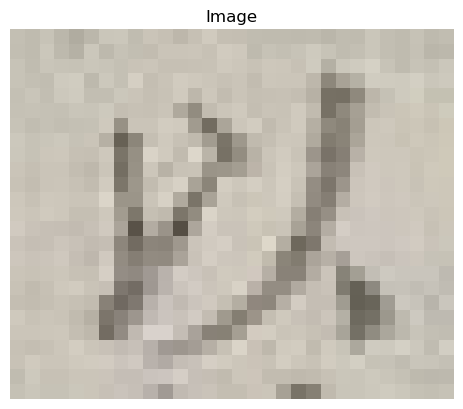

In [63]:
blurred_img = load_image('3/nlvnpf-0140-01-010_crop_30.jpg')
display_image(image=blurred_img)

In [64]:
if len(blurred_img.shape) == 3:
    blurred_img = cv2.cvtColor(blurred_img,cv2.COLOR_BGR2GRAY)

# display_image(blurred_img)
# m = 

In [65]:
denoised_image = cv2.fastNlMeansDenoising(blurred_img)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_image = cv2.filter2D(denoised_image, -1, kernel)
enhanced_image = cv2.addWeighted(sharpened_image, 1.2, sharpened_image, 0, -5)
enhanced_image = cv2.resize(enhanced_image, (blurred_img.shape[1] * 5, blurred_img.shape[0] * 5))
# display_image(sharpened_image)
# display_image(enhanced_image)

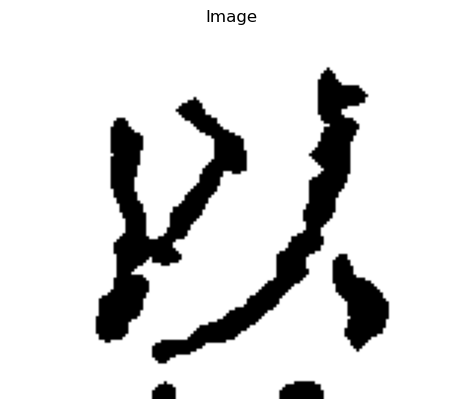

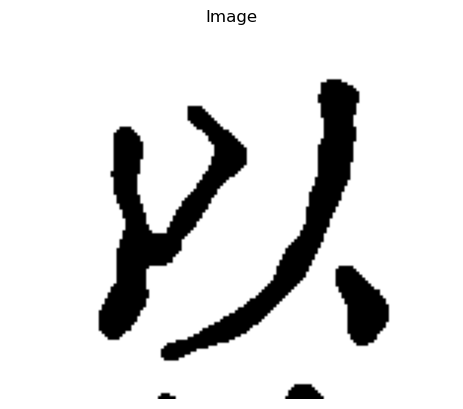

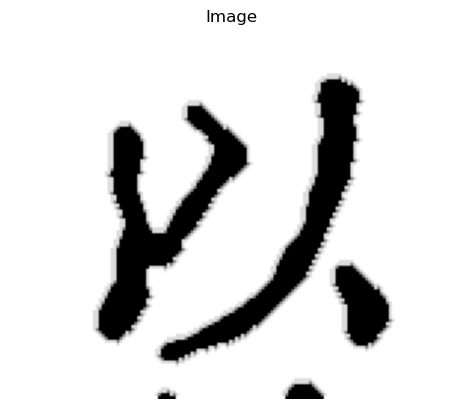

In [66]:
thresh = cv2.threshold(enhanced_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    if cv2.contourArea(c) < 10:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

result = 255 - thresh
# cv2.imshow('result', result)
# cv2.waitKey()
display_image(result)
display_image(remove_noise(result, num=5))
display_image(fill_black(remove_noise(result, num=5)))